<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import os

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

SEED = 12345

In [2]:
def get_df(file_name):
    path_to_file = os.path.relpath(os.path.join('datasets/', file_name))
    if os.path.isfile(path_to_file):
        return pd.read_csv(path_to_file)
    raise Exception('Данные отсутствуют')

In [3]:
df_zero = get_df('geo_data_0.csv')
df_one = get_df('geo_data_1.csv')
df_two = get_df('geo_data_2.csv')

dataframes = (df_zero, df_one, df_two)
names = ('df_zero', 'df_one', 'df_two')
for i in range(len(dataframes)):
    dataframes[i].index.name = names[i]

In [4]:
for df in dataframes:
    df.info()
    display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
df_zero,,,,,
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
df_one,,,,,
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
df_two,,,,,
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832


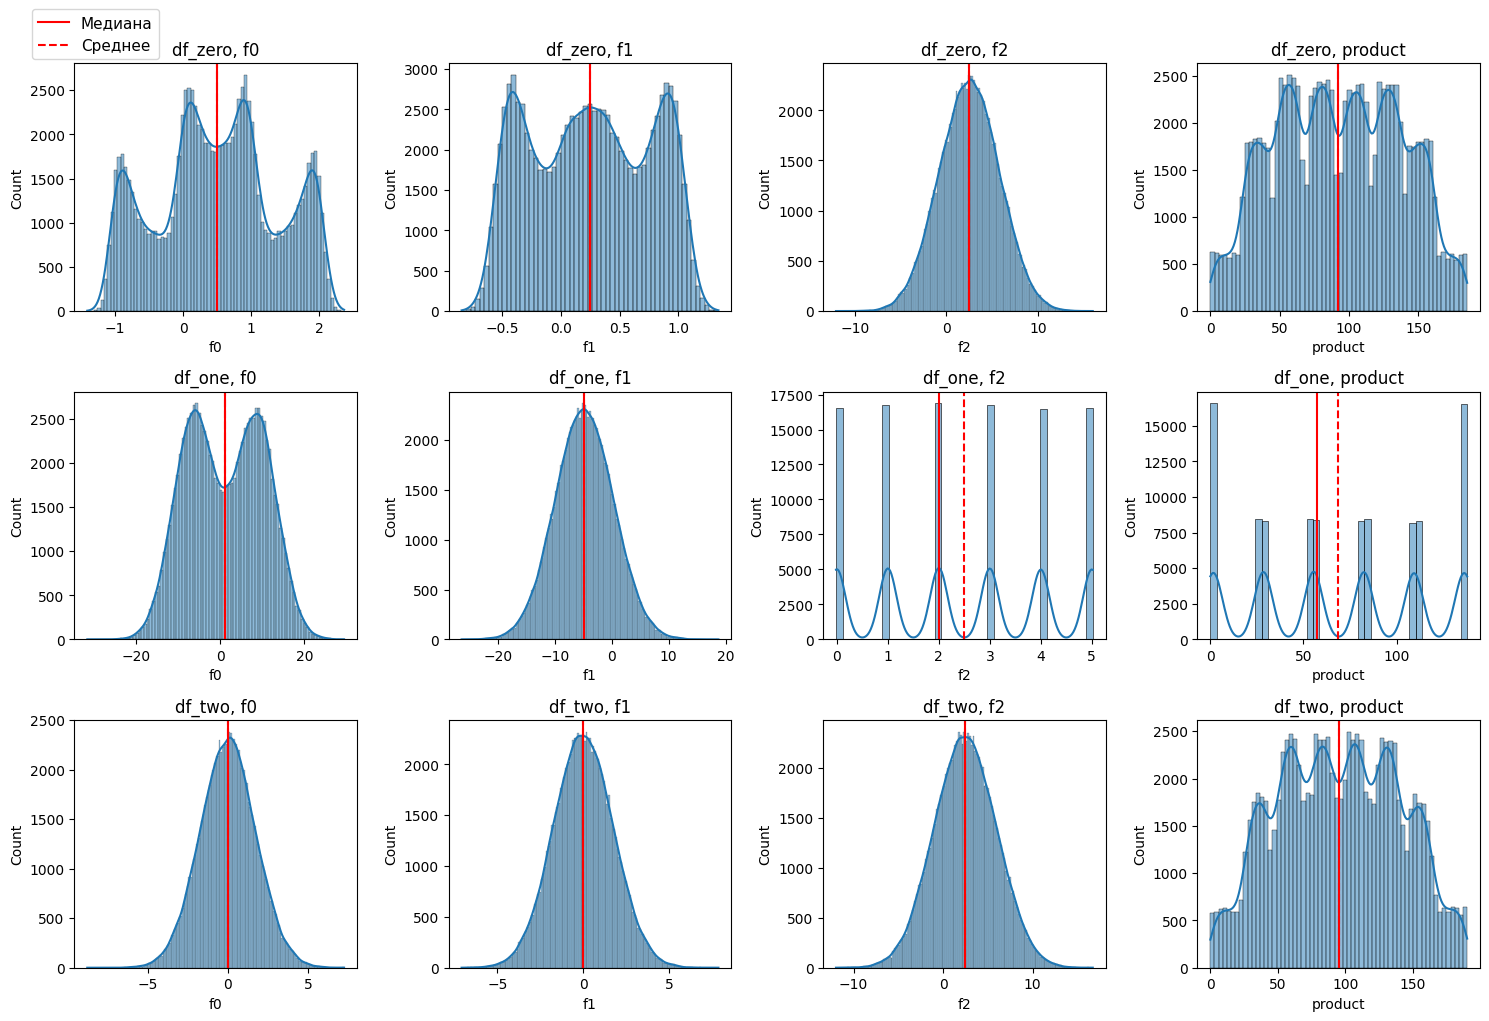

In [5]:
columns = df_zero.drop(['id'], axis=1).columns

fig, axs = plt.subplots(3, 4, figsize=(15, 10))

for i in range(len(dataframes)):
    df = dataframes[i]
    for j in reversed(range(len(columns))):
        col = columns[j]
        mean = df[col].mean()
        median = df[col].median()

        ax = axs[i][j]
        sns.histplot(df[col], kde=True, ax=ax)
        ax.set_title(f'{df.index.name}, {col}')
        ax.axvline(x=median, c='r', label=f'Медиана')
        ax.axvline(x=mean, c='r', ls='--', label=f'Среднее')

plt.tight_layout()
plt.legend(bbox_to_anchor=(-3.65, 3.9), fontsize=11)
plt.show()

In [6]:
duplicates = 0
duplicated_ids = {name: 0 for name in names}

for df in dataframes:
    duplicates += df.duplicated().sum()
    duplicated_ids[df.index.name] = df['id'].duplicated().sum()

if duplicates:
    print('Данные содержат явные дубликаты')
else:
    print('Явные дубликаты отсутствуют')

Явные дубликаты отсутствуют


In [7]:
for key, value in duplicated_ids.items():
    print(f' {key}: {value} неуникальных id')

 df_zero: 10 неуникальных id
 df_one: 4 неуникальных id
 df_two: 4 неуникальных id


Удалим неинформативный признак.

In [8]:
df_zero = df_zero.drop(['id'], axis=1)
df_one = df_one.drop(['id'], axis=1)
df_two = df_two.drop(['id'], axis=1)

display(df_zero.head(3), df_one.head(3), df_two.head(3))

,f0,f1,f2,product
df_zero,,,,
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647


,f0,f1,f2,product
df_one,,,,
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305


,f0,f1,f2,product
df_two,,,,
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910


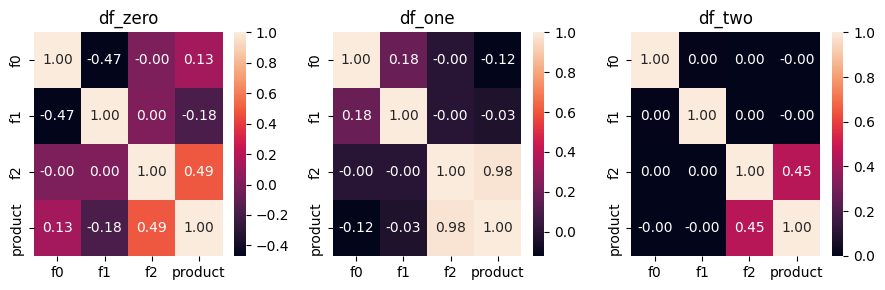

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
num_cols = df.columns[1:].tolist()

for i in range(len(dataframes)):
    df = dataframes[i]
    ax = axs[i]
    sns.heatmap(
        df.corr(method='spearman', numeric_only=num_cols),
        annot=True, fmt='.2f', ax=ax
    )
    ax.set_title(df.index.name)

plt.tight_layout()
plt.show()

**Вывод:**  
- полученные наборы данных состоят из 100 тысяч объектов каждый, содержат 5 числовых переменных;  
- явные дубликаты, пропуски и выбросы отсутствуют;  
- распределения признаков отличаются масштабом разброса значений;  
- целевой признак первого региона имеет дискретное распределение;  
- в первом регионе признак `f2` сильно коррелирует с целевым.

## Обучение и проверка модели

In [10]:
scores = {df.index.name: [] for df in dataframes}

def get_features_target(df):
    features = df.drop('product', axis=1)
    target = df['product']
    return features, target


def get_rmse_r2(features, target):
    regressor = LinearRegression()
    regressor = make_pipeline(StandardScaler(), regressor)
    result = cross_validate(
        regressor, features, target, n_jobs=-1,
        cv=KFold(5, random_state=SEED, shuffle=True),
        scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error',
                 'r2']
    )
    return (
        -result['test_neg_mean_absolute_error'].mean(),
        -result['test_neg_root_mean_squared_error'].mean(),
        result['test_r2'].mean()
    )


def get_predictions(features, target):
    features_train, features_valid, target_train, target_valid = \
        train_test_split(features, target,
                         test_size=.25, random_state=SEED)

    print(features_train.shape[0] == target_train.shape[0])
    print(features_valid.shape[0] == target_valid.shape[0])
    print(f'Размер обучающей выборки: {features_train.shape[0]}')
    print(f'Размер валидационной выборки: {features_valid.shape[0]}')

    regressor = LinearRegression()
    regressor = make_pipeline(StandardScaler(), regressor)
    regressor.fit(features_train, target_train)

    predicted = regressor.predict(features_valid)
    features_valid = features_valid.copy()
    features_valid['target'] = target_valid
    features_valid['predicted'] = predicted
    return features_valid

**Регион 0**

In [11]:
features, target = get_features_target(df_zero)

zero_mae, zero_rmse, zero_r2 = get_rmse_r2(features, target)

print(f'mae = {zero_mae:.2f}\nrmse = {zero_rmse:.2f}\nr2 = {zero_r2:.2f}\n')

zero_valid = get_predictions(features, target)
zero_target_mean = zero_valid['target'].mean()
zero_predicted_mean = zero_valid['predicted'].mean()

scores['df_zero'].extend([zero_mae, zero_rmse, zero_r2, zero_target_mean,
                          zero_predicted_mean])

print('Средний объём запасов в нулевом регионе: '
      f'{zero_target_mean:.0f} тыс. баррелей')
print('Средний объём предсказанных запасов в нулевом регионе: '
      f'{zero_predicted_mean:.0f} тыс. баррелей')

zero_valid.sample(10)

mae = 31.04
rmse = 37.69
r2 = 0.28

True
True
Размер обучающей выборки: 75000
Размер валидационной выборки: 25000
Средний объём запасов в нулевом регионе: 92 тыс. баррелей
Средний объём предсказанных запасов в нулевом регионе: 93 тыс. баррелей


,f0,f1,f2,target,predicted
df_zero,,,,,
10405,0.185313,0.915272,3.475812,100.791787,88.535670
68773,-0.919709,0.602924,-0.479584,37.739874,62.890419
64554,1.060677,0.319235,-1.619824,119.478837,66.487204
10796,0.139742,0.461999,3.047643,144.920421,91.939168
14065,-0.390148,0.957715,-0.062643,40.616249,62.540157
69885,0.765742,-0.522480,5.000020,123.891845,120.939734
47717,1.373199,-0.441246,0.042717,102.638442,89.292658
48507,0.129963,-0.213482,-2.051937,63.628131,67.804548
55986,2.012017,0.500107,-0.403480,105.464626,75.374812


**Регион 1**

In [12]:
features, target = get_features_target(df_one)

one_mae, one_rmse, one_r2 = get_rmse_r2(features, target)
print(f'mae = {one_mae:.2f}\nrmse = {one_rmse:.2f}\nr2 = {one_r2:.2f}\n')

one_valid = get_predictions(features, target)
one_target_mean = one_valid['target'].mean()
one_predicted_mean = one_valid['predicted'].mean()

scores['df_one'].extend([one_mae, one_rmse, one_r2, one_target_mean,
                         one_predicted_mean])

print('Средний объём запасов в первом регионе: '
      f'{one_target_mean:.0f} тыс. баррелей')
print('Средний объём предсказанных запасов в первом регионе: '
      f'{one_predicted_mean:.0f} тыс. баррелей')

one_valid.sample(10)

mae = 0.72
rmse = 0.89
r2 = 1.00

True
True
Размер обучающей выборки: 75000
Размер валидационной выборки: 25000
Средний объём запасов в первом регионе: 69 тыс. баррелей
Средний объём предсказанных запасов в первом регионе: 69 тыс. баррелей


,f0,f1,f2,target,predicted
df_one,,,,,
58945,-6.061565,-9.583229,-0.006708,3.179103,2.564164
15042,2.029427,-0.445516,1.999416,53.906522,55.257576
65918,-6.776420,-6.638120,4.006992,110.992147,110.776851
47296,8.875019,3.476555,4.999098,134.766305,135.023932
29918,13.721828,-4.325625,3.002226,80.859783,80.675243
45309,16.741336,-7.436973,3.000987,80.859783,80.272743
53273,6.720326,-2.845895,4.996097,134.766305,135.394639
4020,7.032295,-9.003062,2.002729,53.906522,54.810255
367,14.845670,-1.715400,-0.006900,0.000000,-0.644639


**Регион 2**

In [13]:
features, target = get_features_target(df_two)

two_mae, two_rmse, two_r2 = get_rmse_r2(features, target)
print(f'mae = {two_mae:.2f}\nrmse = {two_rmse:.2f}\nr2 = {two_r2:.2f}\n')

two_valid = get_predictions(features, target)
two_target_mean = two_valid['target'].mean()
two_predicted_mean = two_valid['predicted'].mean()

scores['df_two'].extend([two_mae, two_rmse, two_r2, two_target_mean,
                         two_predicted_mean])

print('Средний объём запасов во втором регионе: '
      f'{two_target_mean:.0f} тыс. баррелей')
print('Средний объём предсказанных запасов во втором регионе: '
      f'{two_predicted_mean:.0f} тыс. баррелей')

two_valid.sample(10)

mae = 32.82
rmse = 40.06
r2 = 0.20

True
True
Размер обучающей выборки: 75000
Размер валидационной выборки: 25000
Средний объём запасов во втором регионе: 95 тыс. баррелей
Средний объём предсказанных запасов во втором регионе: 95 тыс. баррелей


,f0,f1,f2,target,predicted
df_two,,,,,
13290,0.488953,1.904304,1.792691,80.484523,90.945546
29137,-2.071298,0.186776,0.297251,62.408291,82.401482
58897,-1.355386,0.616199,5.070255,84.745823,109.652544
94510,2.280374,3.516090,2.491371,108.440411,94.921911
1165,1.680063,-1.243627,4.309381,84.802815,105.480847
33835,0.979922,-2.956279,0.591042,136.392163,84.304616
12747,2.724216,2.109052,7.154024,82.303546,121.611518
45485,-0.443252,-0.857305,4.750445,61.667071,107.916821
21990,-1.699660,1.337224,2.072503,129.203418,92.498903


In [14]:
scores = pd.DataFrame(
    scores.values(), index=scores.keys(),
    columns=['mae', 'rmse', 'r2', 'target_mean', 'predicted_mean']
)
scores

,mae,rmse,r2,target_mean,predicted_mean
df_zero,31.038538,37.693547,0.275597,92.078597,92.592568
df_one,0.717419,0.890411,0.999624,68.723136,68.728547
df_two,32.822028,40.057170,0.198676,94.884233,94.965046


**Вывод:**  
- в нулевом и втором регионе средние запасы сырья значительно выше, чем в первом;  
- вероятно, вследствие высокой корреляции между `f2` и целевым признаком модель наиболее точно предсказывает запасы в первом регионе.

## Подготовка к расчёту прибыли

In [15]:
BUDGET = 10e9
SUBSAMPLE_SIZE = 500
COUNT = 200
BUDGET_PER_WELL = BUDGET / COUNT
REVENUE = 4.5e5
LIMIT = BUDGET_PER_WELL / REVENUE

print(f'Точка безубыточности: {LIMIT:.0F} тыс. баррелей\n')
print('Средний объём запасов в нулевом регионе: '
      f'{zero_valid["target"].mean():.0f} тыс. баррелей')
print('Средний объём запасов в первом регионе: '
      f'{one_valid["target"].mean():.0f} тыс. баррелей')
print('Средний объём запасов во втором регионе: '
      f'{two_valid["target"].mean():.0f} тыс. баррелей')

Точка безубыточности: 111 тыс. баррелей

Средний объём запасов в нулевом регионе: 92 тыс. баррелей
Средний объём запасов в первом регионе: 69 тыс. баррелей
Средний объём запасов во втором регионе: 95 тыс. баррелей


**Вывод:**  средний объём запасов в скважине по всем регионам ниже необходимого для безубыточной разработки. 

## Расчёт прибыли и рисков 

In [16]:
def get_profit(target, predictions, budget, rev, count):
    pred_sorted = predictions.sort_values(ascending=False)
    selected = target[pred_sorted.index][:200]
    profit = selected.sum() * rev - budget
    return profit


def bootstrap(target, predictions, size=SUBSAMPLE_SIZE,
              budget=BUDGET, rev=REVENUE, count=COUNT):
    values = []
    state = np.random.RandomState(12345)
    for i in range(1000):
        target_subsample = target.sample(n=size, random_state=state,
                                         replace=True)
        predictions_subsample = predictions[target_subsample.index]
        values.append(get_profit(target_subsample, predictions_subsample,
                                 budget, rev, count))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)

    mean = values.mean()
    print(f'Средняя прибыль: {mean:,.0f}'.replace(',', ' '))
    print(f'2.5%-квантиль: {lower:,.0f}'.replace(',', ' '))
    return lower, upper, values

**Регион 0**

In [17]:
lower_zero, upper_zero, values_zero = \
    bootstrap(zero_valid['target'], zero_valid['predicted'])

scores.loc['df_zero', ['2.5%', '97.5%']] = lower_zero, upper_zero

Средняя прибыль: 425 938 527
2.5%-квантиль: -102 090 095


**Регион 1**

In [18]:
lower_one, upper_one, values_one = \
    bootstrap(one_valid['target'], one_valid['predicted'])

scores.loc['df_one', ['2.5%', '97.5%']] = lower_one, upper_one

Средняя прибыль: 515 222 773
2.5%-квантиль: 68 873 225


**Регион 2**

In [19]:
lower_two, upper_two, values_two = \
    bootstrap(two_valid['target'], two_valid['predicted'])

scores.loc['df_two', ['2.5%', '97.5%']] = lower_two, upper_two

Средняя прибыль: 435 008 363
2.5%-квантиль: -128 880 547


In [20]:
def get_histograms(bins_num=100, lower_zero=lower_zero,
                   lower_one=lower_one, lower_two=lower_two):
    plt.figure(figsize=(15, 8))
    
    ax1 = sns.histplot(values_zero, color='purple', edgecolor='white',
                       label='  нулевой регион',
                       alpha=.1, bins=bins_num, kde=True)
    mean = values_zero.mean()

    ax1.axvline(x=lower_zero, c='green', ls='--',
                label=f'  2.5%-квантиль: {lower_zero:,.0f}'.replace(',', ' '))
    ax1.axvline(x=mean, c='green',
                label=f'\n  среднее: {mean:,.0f}\n'.replace(',', ' '))

    ax2 = sns.histplot(values_two, color='sandybrown', bins=100, alpha=.3,
                       edgecolor='white', label='  второй регион', kde=True)
    mean = values_two.mean()
    ax2.axvline(x=lower_two, c='r', ls='--',
                label=f'  2.5%-квантиль: {lower_two:,.0f}'.replace(',', ' '))
    ax2.axvline(x=mean, c='r',
                label=f'\n  среднее: {mean:,.0f}\n'.replace(',', ' '))

    ax3 = sns.histplot(values_one, edgecolor='white',
                       label='  первый регион',
                       alpha=.4, bins=bins_num, kde=True)
    median = values_one.median()
    mean = values_one.mean()
    ax3.axvline(x=lower_one, c='black', ls='--',
                label=f'  2.5%-квантиль: {lower_one:,.0f}'.replace(',', ' '))
    ax3.axvline(x=mean, c='black',
                label=f'\n  среднее: {mean:,.0f}\n'.replace(',', ' '))

    risk_prob_two = (values_two < 0).mean() * 100
    risk_prob_zero = (values_zero < 0).mean() * 100
    risk_prob_one = (values_one < 0).mean() * 100
    probs = [risk_prob_zero, risk_prob_two, risk_prob_one]

    strings = ['  Нулевой регион', '  Второй регион',
               '  Первый регион', 'Распределения']
    handles, _ = plt.gca().get_legend_handles_labels()
    for extra_string, num in zip(strings, (0, 3, 6, 9)):
        handles.insert(num, mpatches.Patch(color='none', label=extra_string))
    handles.insert(0, mpatches.Patch(color='none', label='Прибыль'))
    
    for prob, num in zip(probs, (2, 6, 10)):
        handles.insert(
            num, mpatches.Patch(
                color='none',
                label=f'  вероятность убытка: {prob:.2f}%\n'
            )
        )

    plt.legend(handles=handles, loc='upper right')
    plt.ylabel('Количество')
    plt.xlabel('Прибыль (миллиарды)')
    plt.title(f'Распределения прибылей (валидационная выборка)')
    plt.grid(True, alpha=.3)

,mae,rmse,r2,target_mean,predicted_mean,2.5%,97.5%
df_zero,31.038538,37.693547,0.275597,92.078597,92.592568,-1.020901e+08,9.479764e+08
df_one,0.717419,0.890411,0.999624,68.723136,68.728547,6.887323e+07,9.315476e+08
df_two,32.822028,40.057170,0.198676,94.884233,94.965046,-1.288805e+08,9.697070e+08


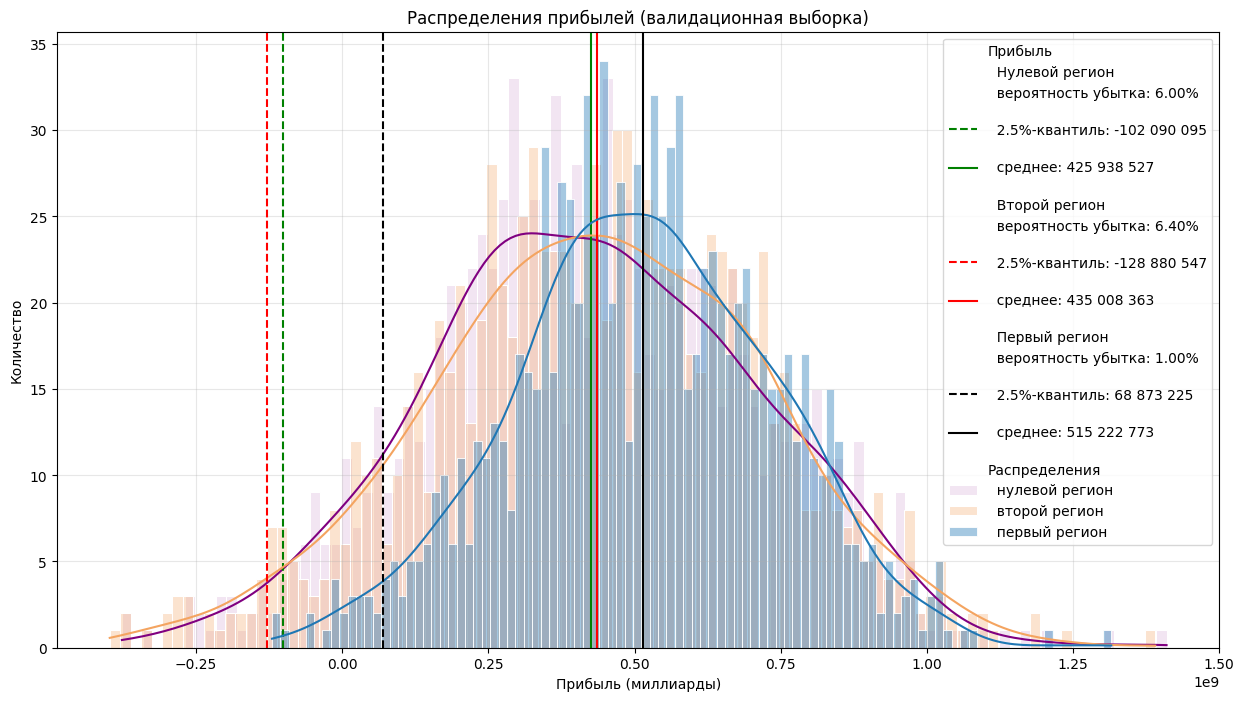

In [21]:
get_histograms()
scores

**Вывод:**  
- наименьший разброс значений у распределения первого региона;  
- в первом регионе наименьший риск получить убыток и наибольшая средняя прибыль.

## Общий вывод

**Описание данных**  
Данные геологоразведки трёх регионов:  
`id` — уникальный идентификатор скважины;  
`f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);  
`product` — объём запасов в скважине (тыс. баррелей).  

**Загрузка и подготовка данных:**  
- явные дубликаты, пропуски и выбросы в загруженных наборах данных отсутствуют;
- неинформативный признак удалён.  

**Исходя из полученных результатов следует:**  
- средние запасы сырья в нулевом и втором регионе значительно выше, чем в первом;  
- модель линейной регрессии наиболее точные предсказания даёт для первого региона;  
- для разработки скважин можно рекомендовать первый регион: наименьший риск получить убыток (1%)  
    и наибольшая средняя прибыль (515 млн).